## Local Multivariate VS Global Univariate
Single multivariate series VS Multiple univariate series

In [15]:
import numpy as np
import pandas as pd
import torch 
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel, RNNModel

### Create Input Series

We’ll use sine and cosine — periodic, interpretable, and clearly different but related.

In [ ]:
# Generate time
time = pd.date_range(start="20230101", periods=100, freq="D")

# Create simple sine and cosine components
sine = np.sin(np.linspace(0, 20, 100))
cosine = np.cos(np.linspace(0, 20, 100))

# Create multivariate series
df = pd.DataFrame({"sine": sine, "cosine": cosine}, index=time)  # Seasonality = 31.4 days 
series = TimeSeries.from_dataframe(df)
series = series.astype(np.float32)

# Normalize (important for neural nets)
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
series_mv = series_scaled                  # Input for Multivariate model 

# Split into separate TimeSeries
series_sine = series_scaled["sine"]
series_cosine = series_scaled["cosine"]
series_list = [series_sine, series_cosine] # Input for Global model 


(100, 2)
(100, 1, 1)
(100, 1, 1)


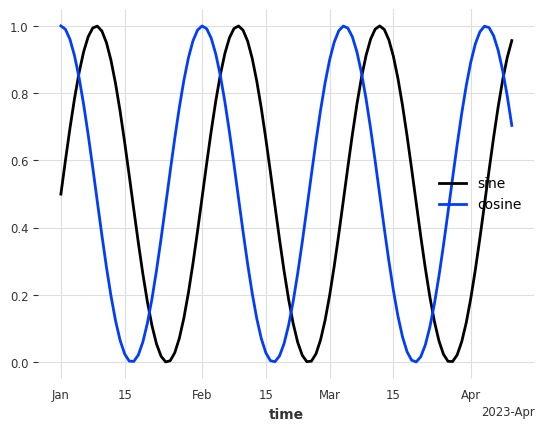

In [10]:
series_mv.plot()

print(series_scaled.values().shape)
print(series_list[0].shape)
print(series_list[1].shape)

### RNN

#### 1. Initialise multivariate model and global model

In [41]:
model_rnn_mv = RNNModel(
    input_chunk_length=30,
    training_length=30+10,
    model='LSTM',
    n_epochs=100,
    random_state=42,
)

model_rnn_mv.fit(series_mv)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.9 K  | train
6 | V               | Linear           | 52     | train
-------------------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=40, input_chunk_length=30, n_epochs=100, random_state=42)

In [42]:
model_rnn_global = RNNModel(
    input_chunk_length=30,
    training_length=30+10,
    model='LSTM',
    n_epochs=100,
    random_state=42
)

model_rnn_global.fit(series_list)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, dropout=0.0, training_length=40, input_chunk_length=30, n_epochs=100, random_state=42)

#### 2. Inspect Model Architecture

In [36]:
print("Multivariate model architecture:")
print(model_rnn_mv.model)
print("Global model architecture:")
print(model_rnn_global.model)

Multivariate model architecture:
_RNNModule(
  (criterion): MSELoss()
  (train_criterion): MSELoss()
  (val_criterion): MSELoss()
  (train_metrics): MetricCollection,
    prefix=train_
  )
  (val_metrics): MetricCollection,
    prefix=val_
  )
  (rnn): LSTM(2, 25, batch_first=True)
  (V): Linear(in_features=25, out_features=2, bias=True)
)
Global model architecture:
_RNNModule(
  (criterion): MSELoss()
  (train_criterion): MSELoss()
  (val_criterion): MSELoss()
  (train_metrics): MetricCollection,
    prefix=train_
  )
  (val_metrics): MetricCollection,
    prefix=val_
  )
  (rnn): LSTM(1, 25, batch_first=True)
  (V): Linear(in_features=25, out_features=1, bias=True)
)


#### 3. Register Hooks to Print Intermediate Shapes

In [37]:
def register_input_hook(model, name=""):
    orig_forward = model.forward

    def wrapped_forward(*args, **kwargs):
        # args[0] is a tuple like (x, ...)
        x_tuple = args[0] if isinstance(args[0], tuple) else args
        x = x_tuple[0]  # the actual model input tensor
        if hasattr(x, 'shape'):
            print(f"[{name}] Raw input to model: shape = {x.shape}")
        else:
            print(f"[{name}] Input is not a tensor. Type: {type(x)}")
        return orig_forward(*args, **kwargs)

    model.forward = wrapped_forward

register_input_hook(model_rnn_mv.model, "Multivariate RNN Input")
register_input_hook(model_rnn_global.model, "Global RNN Input")

In [38]:
_ = model_rnn_mv.predict(10)
_ = model_rnn_global.predict(10, series=series_list) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 30, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])
[Multivariate RNN Input] Raw input to model: shape = torch.Size([1, 1, 2])


Predicting: |          | 0/? [00:00<?, ?it/s]

[Global RNN Input] Raw input to model: shape = torch.Size([2, 30, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])
[Global RNN Input] Raw input to model: shape = torch.Size([2, 1, 1])


#### 4. Conclusion
Input shape: [B,T,F], ie [batch_size, time_steps, input_features]

| Model Mode       | Initial Input Shape | Step Input Shape | Meaning                          |
|------------------|---------------------|------------------|----------------------------------|
| **Multivariate** | `[1, 30, 2]`        | `[1, 1, 2]`      | 1 sequence with 2 features       |
| **Global RNN**   | `[2, 30, 1]`        | `[2, 1, 1]`      | 2 separate 1-feature series      |

Note: change of time steps from 30 to 1 -- after the initial input, Darts predicts one step at a time, feeding the previous forecast back into the model to generate the next one — autoregressive prediction

#### 5. Forecast comparison

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

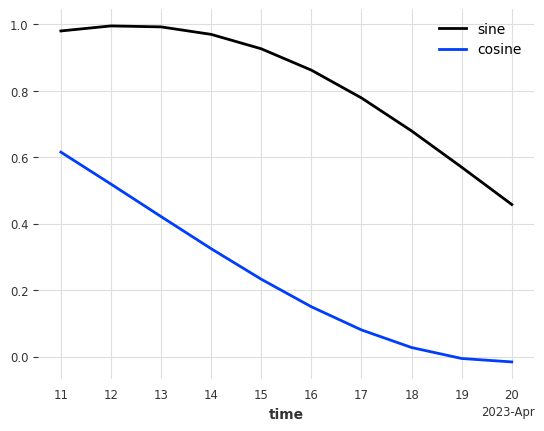

In [43]:
model_rnn_mv.predict(10).plot()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

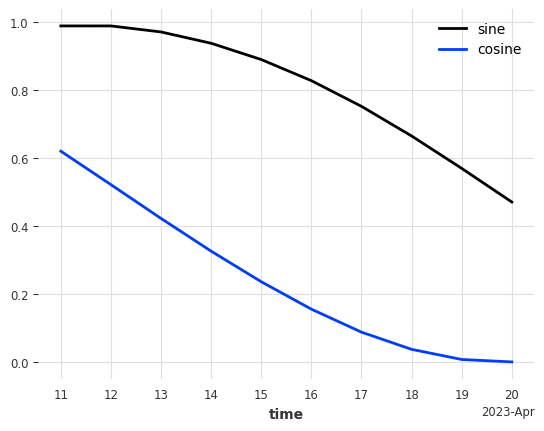

In [44]:
model_rnn_global.predict(10, series = series_list)[0].plot()
model_rnn_global.predict(10, series = series_list)[1].plot()

### N-BEATs

#### 1. Initialise multivariate model and global model

In [45]:
model_nbeats_mv = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    n_epochs=100,
    random_state=42,
)

model_nbeats_mv.fit(series_mv)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.5 M  | train
-------------------------------------------------------------
6.5 M     Trainable params
1.6 K     Non-trainable params
6.5 M     Total params
25.925    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=10, n_epochs=100, random_state=42)

In [46]:
model_nbeats_global = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=10,
    n_epochs=100,
    random_state=42,
)

model_nbeats_global.fit(series_list)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.975    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=10, n_epochs=100, random_state=42)

#### 2. Inspect Model Architecture

In [20]:
print("Multivariate model architecture:")
print(model_nbeats_mv.model)

Multivariate model architecture:
_NBEATSModule(
  (criterion): MSELoss()
  (train_criterion): MSELoss()
  (val_criterion): MSELoss()
  (train_metrics): MetricCollection,
    prefix=train_
  )
  (val_metrics): MetricCollection,
    prefix=val_
  )
  (stacks): ModuleList(
    (0-29): 30 x _Stack(
      (blocks): ModuleList(
        (0): _Block(
          (activation): ReLU()
          (fc_stack): ModuleList(
            (0): Linear(in_features=60, out_features=256, bias=True)
            (1-3): 3 x Linear(in_features=256, out_features=256, bias=True)
          )
          (backcast_linear_layer): Linear(in_features=256, out_features=5, bias=True)
          (forecast_linear_layer): Linear(in_features=256, out_features=5, bias=True)
          (backcast_g): Linear(in_features=5, out_features=60, bias=True)
          (forecast_g): Linear(in_features=5, out_features=20, bias=True)
        )
      )
    )
  )
)


In [21]:
print("Global model architecture:")
print(model_nbeats_global.model)

Global model architecture:
_NBEATSModule(
  (criterion): MSELoss()
  (train_criterion): MSELoss()
  (val_criterion): MSELoss()
  (train_metrics): MetricCollection,
    prefix=train_
  )
  (val_metrics): MetricCollection,
    prefix=val_
  )
  (stacks): ModuleList(
    (0-29): 30 x _Stack(
      (blocks): ModuleList(
        (0): _Block(
          (activation): ReLU()
          (fc_stack): ModuleList(
            (0): Linear(in_features=30, out_features=256, bias=True)
            (1-3): 3 x Linear(in_features=256, out_features=256, bias=True)
          )
          (backcast_linear_layer): Linear(in_features=256, out_features=5, bias=True)
          (forecast_linear_layer): Linear(in_features=256, out_features=5, bias=True)
          (backcast_g): Linear(in_features=5, out_features=30, bias=True)
          (forecast_g): Linear(in_features=5, out_features=10, bias=True)
        )
      )
    )
  )
)


#### 3. Register Hooks to Print Intermediate Shapes

In [22]:
first_block_mv = model_nbeats_mv.model.stacks[0].blocks[0]
first_block_global= model_nbeats_global.model.stacks[0].blocks[0]

def hook_block_input(module, input, output):
    x = input[0]  # input is a tuple
    print(f"[NBEATS First Block Input] shape: {x.shape}")      # should be [batch_size, time * features]
    print(f"[NBEATS First Block Input] example: {x[0, :30]}") 

# Register the hook
first_block_mv.register_forward_hook(hook_block_input)
first_block_global.register_forward_hook(hook_block_input)

In [24]:
_ = model_nbeats_mv.predict(10)
_ = model_nbeats_global.predict(10, series = series_list)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[NBEATS First Block Input] shape: torch.Size([1, 60])
[NBEATS First Block Input] example: tensor([1.0000, 0.4976, 0.9894, 0.3972, 0.9589, 0.3011, 0.9096, 0.2130, 0.8437,
        0.1365, 0.7638, 0.0749, 0.6732, 0.0305, 0.5755, 0.0052, 0.4746, 0.0000,
        0.3748, 0.0151, 0.2801, 0.0500, 0.1943, 0.1031, 0.1209, 0.1724, 0.0629,
        0.2550, 0.0226, 0.3475], device='mps:0')


Predicting: |          | 0/? [00:00<?, ?it/s]

[NBEATS First Block Input] shape: torch.Size([2, 30])
[NBEATS First Block Input] example: tensor([1.0000, 0.9894, 0.9589, 0.9096, 0.8437, 0.7638, 0.6732, 0.5755, 0.4746,
        0.3748, 0.2801, 0.1943, 0.1209, 0.0629, 0.0226, 0.0018, 0.0012, 0.0208,
        0.0600, 0.1170, 0.1895, 0.2747, 0.3690, 0.4686, 0.5695, 0.6675, 0.7587,
        0.8393, 0.9062, 0.9564], device='mps:0')


#### 4. Conclusion
Input shape: [B, T*F]
- N-BEATs & N-HITs are originally univariate 
- Multivariate input is flattened into one long vector by Darts

#### 5. Forecast comparison

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

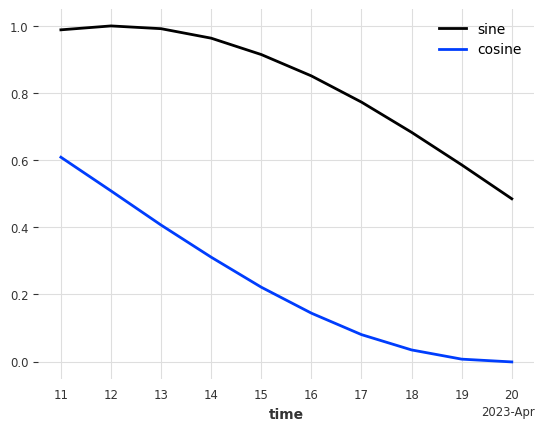

In [47]:
model_nbeats_mv.predict(10).plot()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

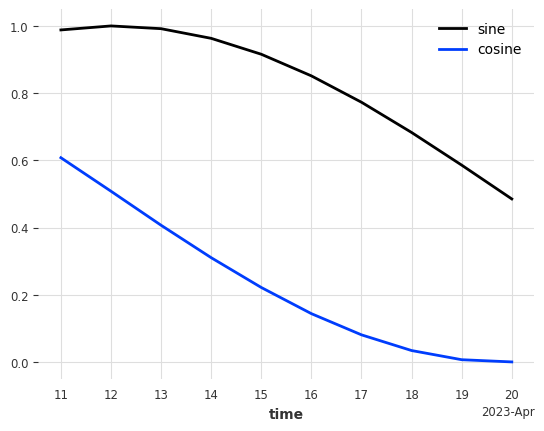

In [48]:
model_nbeats_global.predict(10, series = series_list)[0].plot()
model_nbeats_global.predict(10, series = series_list)[1].plot()